<a href="https://colab.research.google.com/github/MahzadKania57/2D-Keypoints-based-Pose-Classifier/blob/master/Human_skeleton_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/MahzadKania57/2D-Keypoints-based-Pose-Classifier.git

Cloning into '2D-Keypoints-based-Pose-Classifier'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 78 (delta 13), reused 0 (delta 0), pack-reused 51
Unpacking objects: 100% (78/78), 765.36 KiB | 5.00 MiB/s, done.


#Download Dataset

In [3]:
%cd /content/2D-Keypoints-based-Pose-Classifier/
!mkdir dataset/raw
!mkdir dataset/processed

!mkdir dataset-test
!mkdir dataset-test/raw
!mkdir dataset-test/processed

!cp dataset/X_train.txt dataset/raw/
!cp dataset/Y_train.txt dataset/raw/

!cp dataset/X_test.txt dataset-test/raw/
!cp dataset/Y_test.txt dataset-test/raw/

/content/2D-Keypoints-based-Pose-Classifier


In [4]:
from utils import *

In [22]:
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.9/873.9 KB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 36.3 MB/s eta 0:00:00
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=12754c09411580163a1e13bb4c968f15c6fd44ddd8d8db6ee14b1b284b6c4b7e
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/19892810

# **Create edge_index**

In [5]:
from scipy.sparse import csc_matrix
import torch

In [6]:
#create sparse matrix
i = np.array([0, 1, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 5, 6, 6, 7, 8, 8, 9, 9, 10, 11, 11, 12, 12, 13])
j = np.array([1, 0, 2, 5, 8, 11, 1, 3, 2, 4, 3, 1, 6, 5, 7, 6, 1, 9, 8, 10, 9, 1, 12, 11, 13, 12])


degree = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [7]:
edge_index = csc_matrix((degree, (i, j)), shape = (14, 14)).tocoo()

In [8]:
edge_index.size

26

In [9]:
print(edge_index)

  (1, 0)	1
  (0, 1)	1
  (2, 1)	1
  (5, 1)	1
  (8, 1)	1
  (11, 1)	1
  (1, 2)	1
  (3, 2)	1
  (2, 3)	1
  (4, 3)	1
  (3, 4)	1
  (1, 5)	1
  (6, 5)	1
  (5, 6)	1
  (7, 6)	1
  (6, 7)	1
  (1, 8)	1
  (9, 8)	1
  (8, 9)	1
  (10, 9)	1
  (9, 10)	1
  (1, 11)	1
  (12, 11)	1
  (11, 12)	1
  (13, 12)	1
  (12, 13)	1


In [10]:
i = torch.from_numpy(i).to(torch.long)
j = torch.from_numpy(j).to(torch.long)

In [11]:
edge_index =  torch.stack([i,j], dim=0)

# **Create Dataset**

In [23]:
import os.path as osp
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

In [24]:
class SkeletonDataset(Dataset):
    def __init__(self, root, x_root, y_root):
      self.x_root = x_root
      self.y_root = y_root
      super().__init__(root)

    @property
    def raw_file_names(self):
      return [self.x_root, self.y_root]

    @property
    def processed_file_names(self):
      return "data.pt"
        

    def process(self):
      X_ = load_X(self.raw_paths[0])
      Y = load_Y(self.raw_paths[1])

      X = norm_X(X_)
      X = X.reshape(X.shape[0], -1, 2)
      X = X[:, :14, :]

      self.X = torch.from_numpy(X).to(torch.float)
      self.Y = torch.from_numpy(Y).to(torch.long)
      idx = 0
      for i in range(0, X.shape[0]):
        # Read data
        data = Data(x= self.X[i], edge_index=edge_index, y=self.Y[i])
        torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))
        idx += 1

    def len(self):
      return self.X.shape[0]

    def get(self, idx):
      data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
      return data

In [25]:
train_dataset = SkeletonDataset(root='/content/2D-Keypoints-based-Pose-Classifier/dataset', x_root='X_train.txt', y_root='Y_train.txt')

Processing...
Done!


In [26]:
test_dataset = SkeletonDataset(root='/content/2D-Keypoints-based-Pose-Classifier/dataset-test', x_root='X_test.txt', y_root='Y_test.txt')

Processing...
Done!


In [27]:
train_dataset.len(), test_dataset.len()

(2676, 701)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [29]:
for step, data in enumerate(test_loader):
  print(f'Step {step + 1}:')
  print('=======')
  print(f'Number of graphs in the current batch: {data.num_graphs}')
  print(data)

Step 1:
Number of graphs in the current batch: 32
DataBatch(x=[448, 2], edge_index=[2, 832], y=[32], batch=[448], ptr=[33])
Step 2:
Number of graphs in the current batch: 32
DataBatch(x=[448, 2], edge_index=[2, 832], y=[32], batch=[448], ptr=[33])
Step 3:
Number of graphs in the current batch: 32
DataBatch(x=[448, 2], edge_index=[2, 832], y=[32], batch=[448], ptr=[33])
Step 4:
Number of graphs in the current batch: 32
DataBatch(x=[448, 2], edge_index=[2, 832], y=[32], batch=[448], ptr=[33])
Step 5:
Number of graphs in the current batch: 32
DataBatch(x=[448, 2], edge_index=[2, 832], y=[32], batch=[448], ptr=[33])
Step 6:
Number of graphs in the current batch: 32
DataBatch(x=[448, 2], edge_index=[2, 832], y=[32], batch=[448], ptr=[33])
Step 7:
Number of graphs in the current batch: 32
DataBatch(x=[448, 2], edge_index=[2, 832], y=[32], batch=[448], ptr=[33])
Step 8:
Number of graphs in the current batch: 32
DataBatch(x=[448, 2], edge_index=[2, 832], y=[32], batch=[448], ptr=[33])
Step 9:


# **Visualize Graph**

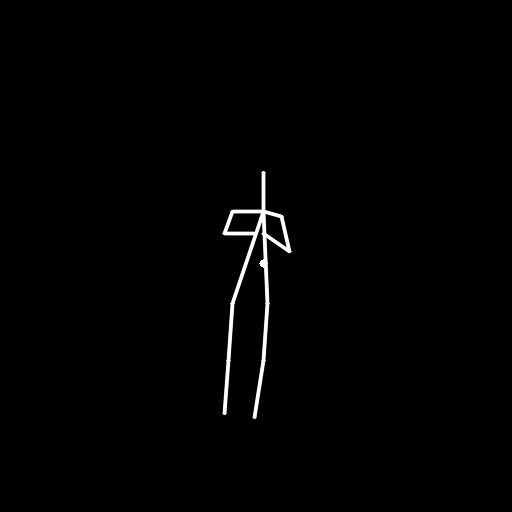

In [30]:
draw_graph(train_dataset[30].x, edge_index)

# **Train The Graph convolution Network**

In [38]:
from torch.nn import Linear, BatchNorm1d
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [39]:
class GCN(torch.nn.Module):
  def __init__(self, hidden_channels, num_node_features, num_classes):
    super().__init__()
    torch.manual_seed(12345)

    self.BN = BatchNorm1d(num_node_features)
    self.conv1 = GCNConv(num_node_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.conv3 = GCNConv(hidden_channels, hidden_channels*2)
    self.conv4 = GCNConv(hidden_channels*2, hidden_channels*2)
    self.lin = Linear(hidden_channels*2, num_classes)

  def forward(self, x, edge_index, batch):
    #1. Obtain node embeddings
    x = self.BN(x)
    x = self.conv1(x, edge_index) 
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = self.conv3(x, edge_index)
    x = F.relu(x)
    x = self.conv4(x, edge_index)

    #2. Readout layers(get graph embeddings)
    x = global_mean_pool(x, batch) #[batch-size, hidden_channels]
  
    #3. Apply a final classifier
    x = F.dropout(x, p=0.3, training= self.training)
    x = self.lin(x)
    
    return x

In [40]:
model = GCN(32, train_dataset.num_node_features, train_dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = torch.nn.CrossEntropyLoss()
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)

In [41]:
print(model)

GCN(
  (BN): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GCNConv(2, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 64)
  (conv4): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=3, bias=True)
)


In [42]:
def train():
  model.train()

  for data in train_loader:
    out = model(data.x, data.edge_index, data.batch)
    loss = loss_fn(out, data.y)
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
   # lr_scheduler.step(loss)
    optimizer.zero_grad() # Clear gradients.

In [43]:
@torch.no_grad()
def test(loader):
  model.eval()

  correct = 0
  for data in loader:
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
  return correct/len(loader.dataset)

In [44]:
for epoch in range(1, 100):
  train()
  train_acc = test(train_loader)
  test_acc = test(test_loader)
  print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.8528, Test Acc: 0.8274
Epoch: 002, Train Acc: 0.8546, Test Acc: 0.8616
Epoch: 003, Train Acc: 0.8558, Test Acc: 0.8417
Epoch: 004, Train Acc: 0.8707, Test Acc: 0.8459
Epoch: 005, Train Acc: 0.8614, Test Acc: 0.8631
Epoch: 006, Train Acc: 0.8647, Test Acc: 0.8488
Epoch: 007, Train Acc: 0.8677, Test Acc: 0.8659
Epoch: 008, Train Acc: 0.9028, Test Acc: 0.8944
Epoch: 009, Train Acc: 0.8995, Test Acc: 0.8930
Epoch: 010, Train Acc: 0.8741, Test Acc: 0.8973
Epoch: 011, Train Acc: 0.8980, Test Acc: 0.8916
Epoch: 012, Train Acc: 0.9099, Test Acc: 0.9030
Epoch: 013, Train Acc: 0.8883, Test Acc: 0.8802
Epoch: 014, Train Acc: 0.9114, Test Acc: 0.8973
Epoch: 015, Train Acc: 0.9122, Test Acc: 0.9016
Epoch: 016, Train Acc: 0.9070, Test Acc: 0.9073
Epoch: 017, Train Acc: 0.9271, Test Acc: 0.9258
Epoch: 018, Train Acc: 0.9025, Test Acc: 0.9001
Epoch: 019, Train Acc: 0.9163, Test Acc: 0.9044
Epoch: 020, Train Acc: 0.9036, Test Acc: 0.8902
Epoch: 021, Train Acc: 0.9133, Test Acc: